# Preparing the data ...

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
data = pd.read_csv('../data/humsavar_dbnsfp53_complete.csv')

In [3]:
data.head()

,Gene,Entry,FTId,AA_change,Category,dbSNP,Disease,Label,chr,pos,ref,alt,rs_dbSNP,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,ABCA4,P78363,VAR_084962,p.Phe2188Ser,LP/P,rs61750658,Stargardt disease 1 (STGD1) [MIM:248200],Pathogenic,1,93998027,A,G,rs61750658,0.049,D,0.765,P,4.435338,25.30,0.860
1,ABCA4,P78363,VAR_008491,p.Asp2177Asn,LB/B,rs1800555,Stargardt disease 1 (STGD1) [MIM:248200],Benign,1,93998061,C,G,rs1800555,0.053,T,0.975,D,2.412747,18.61,0.503
2,ABCA4,P78363,VAR_008491,p.Asp2177Asn,LB/B,rs1800555,Stargardt disease 1 (STGD1) [MIM:248200],Benign,1,93998061,C,T,rs1800555,0.268,T,0.061,B,1.492491,14.14,0.313
3,ABCA4,P78363,VAR_008490,p.Lys2160Arg,LP/P,rs281865405,Stargardt disease 1 (STGD1) [MIM:248200],Pathogenic,1,94000836,T,C,rs281865405,1.000,T,0.051,B,2.740497,20.10,0.577
4,ABCA4,P78363,VAR_008489,p.Cys2150Tyr,LP/P,rs61751384,Stargardt disease 1 (STGD1) [MIM:248200],Pathogenic,1,94000866,C,G,rs61751384,0.000,D,1.000,D,4.731917,26.50,0.937


In [3]:
# drop irrelevant columns (either too many unique values or 'cheating' as they're based on the label'
data = data.drop(columns=['Gene', 'Entry', 'FTId', 'AA_change', 'Category', 'dbSNP', 'Disease', 'rs_dbSNP'])
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,Pathogenic,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,Benign,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,Benign,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,Pathogenic,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,Pathogenic,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [4]:
# Update the values to all be numeric
label_mapping = {'Benign': 0, 'Pathogenic': 1}
data['Label'] = data['Label'].map(label_mapping)
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,0,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,0,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [5]:
# encode chromosomes ('X' and 'Y')
chrom_mapping = {
    **{str(i): i for i in range(1, 23)},  # "1"–"22"
    "X": 23,
    "Y": 24
}
data["chr"] = data["chr"].map(chrom_mapping)
data['chr'].describe()

count    10940.000000
mean        10.453382
std          6.880055
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max         23.000000
Name: chr, dtype: float64

In [14]:
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,0,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,0,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


# Naive Bayes Overview

The goal of this notebook is to explore naive bayes as a learner for our dataset, to see how well it can predict whether a gene is benign or pathogenetic based on the features we provide.

I believe naive bayes can be effective, but even if it falls flat it will be useful as a "baseline" that we want more complex models to surpass (since they require more computational power). 

## Challenges

Naive Bayes requires us to have a known probability distribution for our features when conditioned on our target class. This works fine for discrete values, as we can use their empirical probabilities, but for continuous features it becomes a little more challenging to find a reasonable distribution. 


A common choice is the Gaussian, but looking at graphs of our continuous features conditioned on our target class (see the data exploration notebook for reference) very few of them look Gaussian. Their distributions are usually skewed one way, or multimodal, which means GNB would not accurately model the distribution. 

I looked into alternatives and found a couple of promising options:
1. Bin the data and treat it as a discrete feature. Here we can just use the empirical probabilities.
2. Use a Kernel Density Estimate (KDE) as the distribution of our data.
3. Use an ensemble of learners that each use different distributions for our feature, and balance categorical and and various continuous distributions.

In this notebook, I'll focus on the first two as they seem the most promising.


### Conditional Independence

Another challenge is that our conditional independence assumption doesn't exactly hold. Even when conditioned on the class, SIFT_score and SIFT_pred are dependent, and so are Polyphen2 score/pred. A simple way to fix this is to just use one or the other, since I believe they represent the same information. The same applies with the cadd features

# 1. CategoricalNB

Let's transform all our data into categorical data via binning.

In [18]:
Xcat = data.drop(columns=['Label'])
Ycat = data['Label']

In [19]:
Xcat.head()

,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [20]:
Ycat

0        1
1        0
2        0
3        1
4        1
        ..
10935    0
10936    0
10937    0
10938    0
10939    0
Name: Label, Length: 10940, dtype: int64

In [21]:
# SIFT and Polyphen2_HDIV have binned features already, so we'll keep those and drop the continuous score
Xcat = Xcat.drop(columns=['SIFT_score', 'Polyphen2_HDIV_score'])

In [23]:
Xcat = Xcat.drop(columns=['pos'])
Xcat.head()

,chr,ref,alt,SIFT_pred,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,A,G,D,P,4.435338,25.30,0.860
1,1,C,G,T,D,2.412747,18.61,0.503
2,1,C,T,T,B,1.492491,14.14,0.313
3,1,T,C,T,B,2.740497,20.10,0.577
4,1,C,G,D,D,4.731917,26.50,0.937


In [24]:
# I'm also going to drop CADD_phred and just use CADD_raw
Xcat = Xcat.drop(columns=['CADD_phred'])

In [25]:
# Now, I want to try two kinds of binning: quantile and fixed
# Let's start with quantile, using q=10 to do decile splits
Xcat['qCADD'] = pd.qcut(x=Xcat['CADD_raw'], q=10, duplicates='drop', labels=False)
Xcat.head()

,chr,ref,alt,SIFT_pred,Polyphen2_HDIV_pred,CADD_raw,REVEL_score,qCADD
0,1,A,G,D,P,4.435338,0.860,7
1,1,C,G,T,D,2.412747,0.503,4
2,1,C,T,T,B,1.492491,0.313,3
3,1,T,C,T,B,2.740497,0.577,5
4,1,C,G,D,D,4.731917,0.937,7


In [27]:
# Check that it worked
Xcat['qCADD'].value_counts()

qCADD
6    1095
4    1094
3    1094
5    1094
8    1094
9    1094
1    1094
0    1094
2    1094
7    1093
Name: count, dtype: int64

In [29]:
# Do the same for REVEL_score
Xcat['qREVEL'] = pd.qcut(x=Xcat['REVEL_score'], q=10, duplicates='drop', labels=False)
Xcat['qREVEL'].value_counts()

qREVEL
0    1145
7    1099
8    1097
6    1095
5    1093
4    1093
3    1093
2    1093
9    1083
1    1049
Name: count, dtype: int64

In [32]:
# drop the non-binned versions
Xcat = Xcat.drop(columns=['CADD_raw', 'REVEL_score'])
Xcat.head()

,chr,ref,alt,SIFT_pred,Polyphen2_HDIV_pred,qCADD,qREVEL
0,1,A,G,D,P,7,8
1,1,C,G,T,D,4,6
2,1,C,T,T,B,3,6
3,1,T,C,T,B,5,7
4,1,C,G,D,D,7,9


In [36]:
# Now, we need to make sure each categorical features has values from 1, 2, ..., n - 1 instead of string values
cols_to_encode = ['ref', 'alt', 'SIFT_pred', 'Polyphen2_HDIV_pred']
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(Xcat[cols_to_encode])
# Turn back to a pandas df
encoded_data = pd.DataFrame(encoded_data, columns=[f'{c}_encoded' for c in cols_to_encode], index=Xcat.index)
encoded_data.head()

,ref_encoded,alt_encoded,SIFT_pred_encoded,Polyphen2_HDIV_pred_encoded
0,0.0,2.0,0.0,2.0
1,1.0,2.0,1.0,1.0
2,1.0,3.0,1.0,0.0
3,3.0,1.0,1.0,0.0
4,1.0,2.0,0.0,1.0


In [37]:
# combine with our data
Xcat = pd.concat([Xcat, encoded_data], axis=1)
Xcat.head()

,chr,ref,alt,SIFT_pred,Polyphen2_HDIV_pred,qCADD,qREVEL,ref_encoded,alt_encoded,SIFT_pred_encoded,Polyphen2_HDIV_pred_encoded
0,1,A,G,D,P,7,8,0.0,2.0,0.0,2.0
1,1,C,G,T,D,4,6,1.0,2.0,1.0,1.0
2,1,C,T,T,B,3,6,1.0,3.0,1.0,0.0
3,1,T,C,T,B,5,7,3.0,1.0,1.0,0.0
4,1,C,G,D,D,7,9,1.0,2.0,0.0,1.0


In [38]:
# Drop the non-encoded data
Xcat = Xcat.drop(columns=cols_to_encode)
Xcat.head()

,chr,qCADD,qREVEL,ref_encoded,alt_encoded,SIFT_pred_encoded,Polyphen2_HDIV_pred_encoded
0,1,7,8,0.0,2.0,0.0,2.0
1,1,4,6,1.0,2.0,1.0,1.0
2,1,3,6,1.0,3.0,1.0,0.0
3,1,5,7,3.0,1.0,1.0,0.0
4,1,7,9,1.0,2.0,0.0,1.0


In [44]:
# Now we can train our classifier!
# There's no hyperparemeters to tune, so no need for a validation set
Xcat_tr, Xcat_te, Ycat_tr, Ycat_te = train_test_split(Xcat, Ycat, random_state=0, train_size=0.8)

In [45]:
# Fit our model
catNB = CategoricalNB()
# Fit
catNB.fit(Xcat_tr, Ycat_tr)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,min_categories,None


In [50]:
# Make predictions and get scores
Yhat = catNB.predict(Xcat_te)
print('ACCURACY: ')
print(accuracy_score(Ycat_te, Yhat))
print('F1 SCORE')
print(f1_score(Ycat_te, Yhat))

report = classification_report(Ycat_te, Yhat)
print(report)

ACCURACY: 
0.8903107861060329
F1 SCORE
0.8331015299026425
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1502
           1       0.80      0.87      0.83       686

    accuracy                           0.89      2188
   macro avg       0.87      0.89      0.88      2188
weighted avg       0.89      0.89      0.89      2188



Not bad! For a simple naive bayes model, we get 89% accuracy and a decent F1 score. I thought naive bayes would be able to learn well even in spite of our class imbalances, but precision and recall are still a bit lower for our pathogenic class. Let's see if we can improve this with other variations of naive bayes.

# KDE Naive Bayes

Next, I want to try learning a naive bayes model using a Kernel Density Estimate as the continuous PDF of our features. I got this idea from the graphs in the data exploration, which look like the following:

<Axes: xlabel='CADD_phred'>

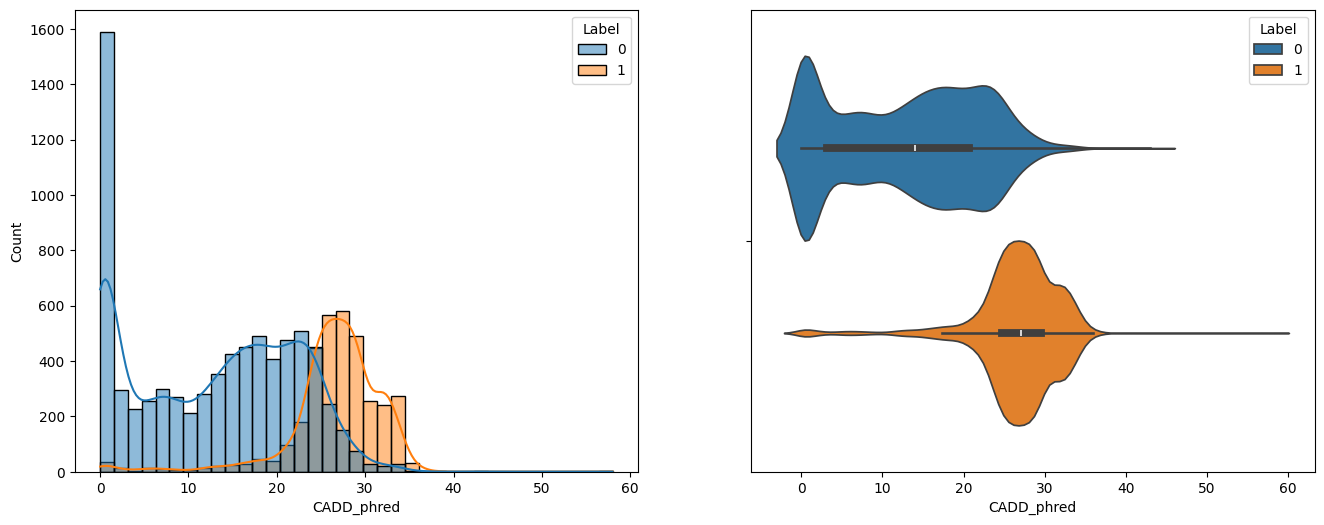

In [54]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.histplot(data=data, x='CADD_phred', hue='Label', kde=True, ax=axes[0])
sns.violinplot(data=data, x='CADD_phred', hue='Label', ax=axes[1])

These graphs use KDEs to estimate the distribution of the data, and they look very promising as a good continuous estimate. Of course, we're trading off some of our computational speed since now we have to estimate the probabilities from this complicated PDF, but I'm curious to see how much our accuracy can improve.

Unfortunately scikit-learn does not have this estimator built in, so I'll have to make it myself. Fortunately, they do have a KernelDensity function which can create these densities for me. 

In [17]:
class KDENaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=0.2, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.classes = None
        self.models = {}
        self.priors = {}

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        self.classes = np.unique(y)
        
        for c in self.classes:
            X_given_c = X[y == c]
            self.priors[c] = len(X_given_c) / len(X)
            self.models[c] = []

            for feature_i in range(X.shape[1]):
                kde = KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel)
                kde.fit(X_given_c[:, feature_i].reshape(-1,1))
                self.models[c].append(kde)

        return self
    def predict(self, X):
        X = np.array(X)
        
        log_probs = []
      
        for c in self.classes:
            class_log_probs = np.log(self.priors[c])
        
            for feature_i, model in enumerate(self.models[c]):
                class_log_probs += model.score_samples(X[:, feature_i].reshape(-1, 1))

            log_probs.append(class_log_probs)
    
        log_probs = np.array(log_probs).T
        return self.classes[np.argmax(log_probs, axis=1)]

In [57]:
# Now let's try this model on our continuous features!
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,0,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,0,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [6]:
features = ['SIFT_score', 'Polyphen2_HDIV_score', 'CADD_raw', 'REVEL_score']
Xkde = data[features]
ykde = data['Label']

In [7]:
# Let's use the standard scalar this time to make the KDE estimates a little better
Xkde_tr, Xkde_te, ykde_tr, ykde_te = train_test_split(Xkde, ykde, random_state=0, train_size=0.8)

In [8]:
scaler = StandardScaler()
scaler.fit_transform(Xkde_tr)
scaler.transform(Xkde_te)

array([[ 2.56732095, -1.14763097, -0.79160551, -0.52895415],
       [-0.14417939,  1.04214492, -0.51056889, -0.7022983 ],
       [-0.66065564,  1.04214492,  1.08917134,  1.6811837 ],
       ...,
       [-0.5702723 ,  0.9348459 ,  0.52477653,  0.00552363],
       [-0.06670795, -0.4184356 , -0.48096554, -0.89008779],
       [-0.23133476,  0.98740052,  0.92174271,  1.41250028]])

### Hyperparameter Tuning

This naive bayes implementation does have hyperparameters to tune, namely the parameters of our kernel density estimate. 

While we could try all things, like the bandwidth, algorithm, learner, etc. I'm going to focus on the bandwidth as I expect it to have the greatest impact.

There are built in estimators for KDE bandwidth which I will be using as well, but I'm also curious to see how manually trying to tune these parameters might look. I expect it to perform *worse* than the built in estimators, since our manual tuning means that each feature's KDE will share a bandwidth, whereas allowing the built in estimator to work means each will get its own custom bandwidth. But, I'm still curious to see what happens.

We'll be using sklearn's grid search cross validation.

In [28]:
# build our search space INCLUDING the built in estimators
search_space = {'bandwidth': [0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 'scott', 'silverman']}
grid_search = GridSearchCV(KDENaiveBayes(), search_space, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(Xkde_tr, ykde_tr)

,estimator,KDENaiveBayes()
,param_grid,"{'bandwidth': [0.05, 0.1, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,bandwidth,0.1


In [30]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.224385,0.077365,34.849785,0.405037,0.05,{'bandwidth': 0.05},0.844327,0.842105,0.828014,0.838990,0.814442,0.833576,0.011088,4
1,0.180534,0.056447,38.923391,0.491268,0.1,{'bandwidth': 0.1},0.846290,0.845378,0.831858,0.843585,0.821338,0.837690,0.009687,1
2,0.253841,0.062477,40.558513,0.460685,0.2,{'bandwidth': 0.2},0.841171,0.845118,0.824889,0.839965,0.814626,0.833154,0.011536,5
3,0.162450,0.030103,42.175552,0.397939,0.3,{'bandwidth': 0.3},0.838028,0.836394,0.815929,0.824454,0.803390,0.823639,0.012960,6
4,0.167367,0.024677,43.201093,0.201696,0.4,{'bandwidth': 0.4},0.829396,0.823821,0.808134,0.818339,0.799663,0.815871,0.010722,7


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '0.05'),
  Text(1, 0, '0.1'),
  Text(2, 0, '0.2'),
  Text(3, 0, '0.3'),
  Text(4, 0, '0.4'),
  Text(5, 0, '0.5'),
  Text(6, 0, '0.6'),
  Text(7, 0, '0.7'),
  Text(8, 0, '0.8'),
  Text(9, 0, '0.9'),
  Text(10, 0, '1.0'),
  Text(11, 0, 'scott'),
  Text(12, 0, 'silverman')])

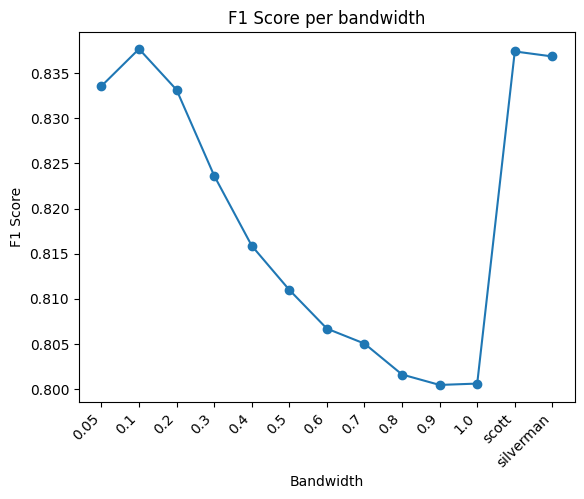

In [31]:
plt.plot(results['param_bandwidth'].astype(str), results['mean_test_score'], marker='o')
plt.title('F1 Score per bandwidth')
plt.xlabel('Bandwidth')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right') 

We can see from this graph that the best bandwidth is 0.1, or the 'scott' estimator. 

I was surprised that the higher bandwidth consistently reduced the F1 score, because I assumed very low bandwidth would overfit to our training distribution, picking up on all the noise that does not actually reflect the true distributions. But clearly this wasn't the case! 

I'm a bit more inclined to use the 'scott' estimator, since it worked almost as well as 0.01, since it allows a different bandwidth per feature. But, since our data says it's not the best, I'll use 0.1 to train my final model.

I went back and added an additional value, 0.05, because I was curious if lowering the bandwidth even more would be better. But, unfortunatley, it did seem to overfit at this point and our F1 score went down.

In [32]:
# Training our model at 0.1
kdeBayes = KDENaiveBayes(bandwidth=0.1)
kdeBayes.fit(Xkde_tr, ykde_tr)

,bandwidth,0.1
,kernel,'gaussian'


In [34]:
ykde_hat = kdeBayes.predict(Xkde_te)
print('ACCURACY: ')
print(accuracy_score(ykde_te, ykde_hat))
print('F1 SCORE:')
print(f1_score(ykde_te, ykde_hat))
report = classification_report(ykde_te, ykde_hat)
print(report)

ACCURACY: 
0.899908592321755
F1 SCORE:
0.8478109798471161
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1502
           1       0.81      0.89      0.85       686

    accuracy                           0.90      2188
   macro avg       0.88      0.90      0.89      2188
weighted avg       0.90      0.90      0.90      2188



# Takeaways

Naive Bayes seemed like a good choice for a classifier because our data is conditionally independent (with the exception of a few features, which we took care of) and because the imbalance of our classes doesn't have as much of an impact for our naive bayes learner, given that the conditional likelihood distributions has enough data to be accurate for both. It's also captured in the prior probabilities, so it's a great model all around. 

Our categorical naive bayes classifier with binning of continuous features produced pretty solid results, getting accuracy around 89% and f1 score around 83%. It's fast and performative, so a very solid model.

Our KDE naive bayes is a bit more complex and takes much longer to predict, but the accuracy and f1 score didn't improve too drastically. For the dataset of our size it's feasible to use that instead, but the results weren't that much better.